# Figure 14

In [1]:
import os
import numpy as np
from scipy.interpolate import interp1d

import pysynphot as S

import astropy.io.ascii as asci
from astropy.table import Table

import astropy.constants as const
Msun = const.M_sun.cgs.value
c = const.c.cgs.value

kappa_opt = 0.07
v_phot = 2e+4 * 1e+5 # cm/s

from arnett import model_arnett_modified
from fit_utils import cc_bol, flux2lum

In [2]:
import matplotlib
import matplotlib.pyplot as plt
fs= 10
matplotlib.rcParams['font.size']=fs
ms = 6
matplotlib.rcParams['lines.markersize']=ms

In [3]:
nu_pool = {
 'r.ztf': 471994480402802.2,
 'g.ztf': 634121907623677.2,
 'i.ztf': 380021535091050.1,
 'o.atlas': 450003936111481.4,
 'c.atlas': 575819723942441.0}

wave_pool = { 
 'r.ztf': 6356.006530923384,
 'g.ztf': 4730.95151568295,
 'i.ztf': 7894.289462520127,
 'o.atlas': 6666.608354414031,
 'c.atlas': 5209.963944027523}

In [4]:
def create_new_yticks2(ylims2, which = "major"):
    yticks2_new = []
    if which=="major":
        candi = np.arange(12, 15.4, 0.2)
    else:
        candi = np.arange(12, 15.25, 0.05)
    for x in candi:
        if x>ylims2[0] and x<ylims2[1]:
            yticks2_new.append(x)
    yticks2_new = np.array(yticks2_new)
    return yticks2_new

In [5]:
def get_Lbol_at2020mrf(SNT = 3, remove_atlas = True):
    # it's better to get the bolometric light curve  to be compared with literature events
    T = 1e+4
    t0 = 59012   
    z = 0.1353
    
    name = "ZTF20abfhyil"
    fname = '../data/data_20mrf/phot/%s_all_lc.dat'%(name)
    lc_data = asci.read(fname)

    # convert to rest-frame days
    nu_all_obs = np.array([nu_pool[x['filter']] for x in lc_data])
    nu_all = nu_all_obs * (1+z) # rest-frame wavelength used for fit

    # convert to luminosity: nuLnu 
    # not that this quantity is the same in either rest-frame or observer's frame
    lum_all = np.array(flux2lum(lc_data["uJy.0"], nu_all_obs, z))
    e_lum_all = np.array(flux2lum(lc_data["duJy.0"], nu_all_obs, z))

    fac_all = 1 / cc_bol(T, nu_all) # from nuLnu to bolometric luminosity
    
    lc_data["L_bol"] = lum_all * fac_all
    lc_data["L_bol_unc"] = e_lum_all * fac_all
    lc_data["phase_rest"] = (lc_data['mjd'] - t0) /(1+z) 
    ix = lc_data["uJy.0"] > (lc_data["duJy.0"]*SNT)
    lc = lc_data[ix]
    if remove_atlas:
        ix = [x[-5:]!="atlas" for x in lc["filter"]]
        ix = np.array(ix)
        lc = lc[ix]
    return lc

In [6]:
def plot_Lbol():
    lc = get_Lbol_at2020mrf(SNT = 2.5)
    
    plt.figure(figsize = (4.8, 3.6))
    ax = plt.subplot(111)
    
    ix1 = lc["phase_rest"]<5
    #ix2 = lc["phase_rest"]>30
    ix = (~ix1) #& (~ix2)
    
    x = lc["phase_rest"][ix1]
    y = np.log10(lc["L_bol"][ix1])
    yerr = lc["L_bol_unc"][ix1] / lc["L_bol"][ix1] / np.log(10)
    ax.errorbar(x, y, yerr, fmt = "^", markersize = ms-1,
                color = "k", alpha = 1, markerfacecolor = "white")
    x = lc["phase_rest"][ix]
    y = np.log10(lc["L_bol"][ix])
    yerr = lc["L_bol_unc"][ix] / lc["L_bol"][ix] / np.log(10)
    ax.errorbar(x, y, yerr, fmt = "o", markersize = ms-1, color = "k", alpha = 1, label = "AT2020mrf")
    
    custom_ax(ax)
    ax.legend(loc = "upper right")
    
    plt.tight_layout(rect = (-0.03, -0.03, 1.04, 1.03))

In [7]:
def custom_ax(ax, do_models = True):
    
    ax.tick_params(which = 'major', length = 4, top=True, direction = "in", right = False)
    ax.tick_params(which = 'minor', length = 2, top=True, direction = "in", right = False)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.set_xlabel("Rest-frame Days Since Explosion")
    ax.set_ylabel("log"+r"$L_{\rm bol}$"+" (erg/s)")
    
    ymin = np.log10(9e+41)
    ymax = 43.9
    ax.set_ylim(ymin, ymax)   

    ########## right y axis ##########
    # right side show the Radius evolution
    axi2 = ax.twinx()
    axi2.tick_params(which = 'major', length = 4, direction = "in")
    axi2.tick_params(which = 'minor', length = 2, direction = "in")

    T = 1e+4 # K
    multi = 4 * np.pi * const.sigma_sb.cgs.value * T**4
    ymax2 = np.log10(np.sqrt( 10**ymax / multi))
    ymin2 = np.log10(np.sqrt( 10**ymin / multi))
    ylims2 = (ymin2, ymax2)
    yticks2_label = create_new_yticks2(ylims2, which = "major")
    yticks2_real = []
    for x in yticks2_label:
        R_cm = 10**x
        temp = np.log10(R_cm**2 * multi)
        yticks2_real.append(temp)
    yticks2_real = np.array(yticks2_real)
    
    yticks2_label_minor = create_new_yticks2(ylims2, which = "minor")
    yticks2_real_minor = []
    for x in yticks2_label_minor:
        R_cm = 10**x
        temp = np.log10(R_cm**2 * multi)
        yticks2_real_minor.append(temp)
    yticks2_real_minor = np.array(yticks2_real_minor)
    
    axi2.set_ylim(ymin, ymax)
    axi2.set_yticks(yticks2_real, minor = False)
    #axi2.set_yticklabels(yticks2_label, minor = False)
    yticks2_label_text = []
    for x in yticks2_label:
        yticks2_label_text.append("%.1f"%x)
    axi2.set_yticklabels(yticks2_label_text, minor = False)
    axi2.set_yticks(yticks2_real_minor, minor = True)
    axi2.set_ylabel("log"+r"$R_{\rm bb}$"+" (cm)")
    
    xmin = -1
    xmax = 37
    ax.set_xlim(xmin, xmax)

    # compare to 1998bw (see Figure 7 of Olivares+2012)
    
    dt = asci.read("./98bw_Lbol/98bw_Lbol")
    color = "salmon"
    ax.plot(dt["x"], np.log10(10**dt["y"]*0.7), color = color, label = "SN1998bw"+r"$\times0.7$", linewidth = 2)
    
    if do_models:
        # fit a model by eye....
        ts_ = np.linspace(0 , 40, 401)
        
        Mni_ = 0.4
        Mej_ = 1.3
        Mej = Mej_ * Msun
        taum = np.sqrt(2 * kappa_opt * Mej / 13.8 / v_phot / c) 
        taum_ = taum / 24/3600
        Ls = model_arnett_modified(ts_, taum_ = taum_, Mni_ = Mni_, t0_ = 30)
        ax.plot(ts_, np.log10(Ls), color = "tab:orange", linewidth = 1,
                linestyle = "-.",
                label = r"$M_{\rm ej} = 1.3\,M_\odot, M_{\rm Ni} = 0.4\,M_\odot$")
        
        Mni_ = 0.35
        Mej_ = 5.7
        Mej = Mej_ * Msun
        taum = np.sqrt(2 * kappa_opt * Mej / 13.8 / v_phot / c) 
        taum_ = taum / 24/3600
        Ls = model_arnett_modified(ts_, taum_ = taum_, Mni_ = Mni_, t0_ = 30)
        ax.plot(ts_, np.log10(Ls), color = "tab:green", linewidth = 1,
                linestyle = "--",
                label = r"$M_{\rm ej} = 5.7\,M_\odot, M_{\rm Ni} = 0.35\,M_\odot$")

/var/folders/51/8dbdmtw12rn86njf20zwrsc80000gn/T/ipykernel_63332/2966940623.py:73: RuntimeWarning: divide by zero encountered in log10
  ax.plot(ts_, np.log10(Ls), color = "tab:orange", linewidth = 1,
/var/folders/51/8dbdmtw12rn86njf20zwrsc80000gn/T/ipykernel_63332/2966940623.py:83: RuntimeWarning: divide by zero encountered in log10
  ax.plot(ts_, np.log10(Ls), color = "tab:green", linewidth = 1,


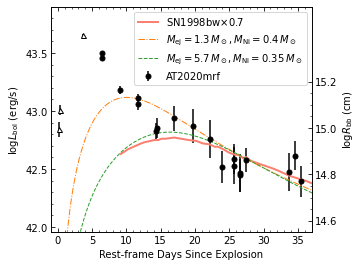

In [8]:
plot_Lbol()